## RCでローレンツ方程式の予測

In [2]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt

In [3]:
class ReservoirNetWork:
    def __init__(self, inputs, num_input_nodes, num_reservoir_nodes, num_output_nodes, leak_rate=0.1, activator=np.tanh):
        self.inputs = inputs  # 学習で使う入力。次の時刻の値。
        self.log_reservoir_nodes = np.array([np.zeros(num_reservoir_nodes)]) # reservoir層のノードの状態を記録。x(t)のこと。

        # 重みの初期化。中間層のサイズは150*150
        self.weights_input = self._generate_variational_weights(num_input_nodes, num_reservoir_nodes)
        self.weights_reservoir = self._generate_reservoir_weights(num_reservoir_nodes)
        self.weights_output = np.zeros([num_reservoir_nodes, num_output_nodes])

        # それぞれの層のノードの数
        self.num_input_nodes = num_input_nodes
        self.num_reservoir_nodes = num_reservoir_nodes
        self.num_output_nodes = num_output_nodes

        self.leak_rate = leak_rate # 漏れ率
        self.activator = activator # 活性化関数

    # reservoir層のノードの次の状態を取得。1つ目の式
    def _get_next_reservoir_nodes(self, input, current_state):
        next_state = (1 - self.leak_rate) * current_state
        next_state += self.leak_rate * (np.array(input) @ self.weights_input
            + current_state @ self.weights_reservoir)
        return self.activator(next_state)

    # 出力層の重みを更新。全時間分を一度に更新する。
    def _update_weights_output(self, lambda0):
        # リッジ回帰
        E_lambda0 = np.identity(self.num_reservoir_nodes) * lambda0  # λI
        inv_x = np.linalg.inv(self.log_reservoir_nodes.T @ self.log_reservoir_nodes + E_lambda0)
        # 出力層の更新
        self.weights_output = (inv_x @ self.log_reservoir_nodes.T) @ self.inputs

    # 学習する
    def train(self, lambda0=0.1):
        for input in self.inputs:
            current_state = np.array(self.log_reservoir_nodes[-1])  # x(t)の値は、一番最後に計算した最新の値
            self.log_reservoir_nodes = np.append(self.log_reservoir_nodes,  # 今までのx(t)に新しいのを付け加える
                [self._get_next_reservoir_nodes(input, current_state)], axis=0)
        self.log_reservoir_nodes = self.log_reservoir_nodes[1:]  # 初期値x(0)を除外して、x[1:T]を新たにx[0:(T-1)]とする。
        self._update_weights_output(lambda0)  # 出力層を一気に更新


    # 訓練データでの出力値の確認
    def get_train_result(self):
        outputs = []
        reservoir_nodes = np.zeros(self.num_reservoir_nodes)
        for input in self.inputs:
            reservoir_nodes = self._get_next_reservoir_nodes(input, reservoir_nodes)  # 入力から中間層へ
            outputs.append(self.get_output(reservoir_nodes))
        return np.array(outputs)  # 次の時刻の値が求まるので、グラフに書く時は1ステップずらすべきでは？

    # 予測する
    def predict(self, length_of_sequence, lambda0=0.01):
        predicted_outputs = [self.inputs[-1]] # 最初にひとつ目だけ学習データの最後のデータを使う
        reservoir_nodes = self.log_reservoir_nodes[-1] # 訓練の結果得た最後の内部状態を取得
        for _ in range(length_of_sequence):  # 予測した値を次の入力値とする。
            reservoir_nodes = self._get_next_reservoir_nodes(predicted_outputs[-1], reservoir_nodes)
            predicted_outputs.append(self.get_output(reservoir_nodes))
        return np.array(predicted_outputs[1:]) # 最初に使用した学習データの最後のデータを外して返す

    # 各時刻tにおける出力値の計算
    def get_output(self, reservoir_nodes):
        # return self.activator(reservoir_nodes @ self.weights_output) 修正前
        return reservoir_nodes @ self.weights_output # 修正後


    # 重みを0.1か-0.1で初期化したものを返す
    def _generate_variational_weights(self, num_pre_nodes, num_post_nodes):
        return (np.random.randint(0, 2, num_pre_nodes * num_post_nodes).reshape([num_pre_nodes, num_post_nodes]) * 2 - 1) * 0.1

    # Reservoir層の重みを初期化
    def _generate_reservoir_weights(self, num_nodes):
        weights = np.random.normal(0, 1, num_nodes * num_nodes).reshape([num_nodes, num_nodes])  # 正規分布
        spectral_radius = max(abs(linalg.eigvals(weights)))  # 固有値の絶対値の最大を求める
        return weights / spectral_radius  # 正規分布を固有値の最大で割ったものが中間層の重み


In [4]:
# 入力データ生成
def lorenz(x, y, z, s=10, r=28, b=8/3):
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return x_dot, y_dot, z_dot


def get_lorenz(dt, num_steps):
    # 空の配列を生成
    xs = np.empty(num_steps)
    ys = np.empty(num_steps)
    zs = np.empty(num_steps)
    # 初期条件
    xs[0], ys[0], zs[0] = (1, 1, 1)

    # 点列の座標生成
    for i in range(num_steps-1):
        x_dot, y_dot, z_dot = lorenz(xs[i], ys[i], zs[i])
        xs[i + 1] = xs[i] + (x_dot * dt)
        ys[i + 1] = ys[i] + (y_dot * dt)
        zs[i + 1] = zs[i] + (z_dot * dt)
    
    # 0から1へスケーリング
    xs = (xs-min(xs))/(max(xs)-min(xs))
    ys = (ys-min(ys))/(max(ys)-min(ys))
    zs = (zs-min(zs))/(max(zs)-min(zs))
    
    return xs, ys, zs



In [11]:
dt = 0.02
num_steps = 10000  # 学習はokだけど、予測がでかくなりすぎ

T = dt * num_steps
RATIO_TRAIN = 0.9  # 学習に使うデータの割合
LEAK_RATE = 0.02
NUM_INPUT_NODES = 3
NUM_RESERVOIR_NODES = 200
NUM_OUTPUT_NODES = 3

[0.50955152 0.5017489  0.00099309]
[0.50955152 0.50955152 0.51186662 ... 0.54147028 0.53781381 0.53604909]


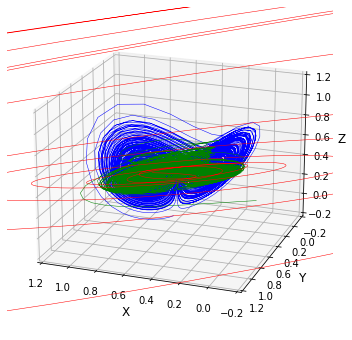

In [12]:
# main
data = get_lorenz(dt, num_steps)
data = np.array(data).transpose()
print(data[:][0])  # これできない？
print(data[:, 0])
num_train = int(len(data) * RATIO_TRAIN)
train_data = data[:num_train]
test_data = data[num_train:]

model = ReservoirNetWork(inputs=train_data,
    num_input_nodes=NUM_INPUT_NODES, 
    num_reservoir_nodes=NUM_RESERVOIR_NODES, 
    num_output_nodes=NUM_OUTPUT_NODES, 
    leak_rate=LEAK_RATE)

model.train() # 訓練
train_result = model.get_train_result()  # 訓練データでの出力値の確認

num_predict = int(len(test_data))
predict_result = model.predict(num_predict)  # num_predictステップ、値の予測

# 曲線の3Dプロット
ax = plt.figure(figsize=(10, 6)).add_subplot(projection='3d')
ax.view_init(elev=20, azim=110)
ax.plot(data[:, 0], data[:, 1], data[:, 2], lw=0.5, c="b")
ax.plot(train_result[:, 0], train_result[:, 1], train_result[:, 2], lw=0.5, c="g")
ax.plot(predict_result[:, 0], predict_result[:, 1], predict_result[:, 2], lw=0.5, c="r")
ax.set_xlabel("X", size=12)
ax.set_ylabel("Y", size=12)
ax.set_zlabel("Z", size=12)
ax.set_xlim([-0.2, 1.2])
ax.set_ylim([-0.2, 1.2])
ax.set_zlim([-0.2, 1.2])

plt.show()

